In [223]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet ###REMOVE
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [224]:
# Defining the seasons and models used
seasons = ['2023-24','2022-23',
           '2021-22','2020-21','2019-20','2018-19','2017-18','2016-17','2015-16','2014-15','2013-14',
          '2012-13','2011-12','2010-11','2009-10','2008-09','2007-08','2006-07', '2005-06', '2004-05', '2003-04'
          ]
seasons.reverse()
           
models = ['SVM', 'XGBoost','Random Forest','AdaBoost','Gradient Boosting',]#'LGBM']

path = current_path = os.getcwd()
# Path to local folder
path_data = '/Users/von/Desktop/Work/Projects/NBA_MIP_Predictor/WNBA-MVP'

test_number = 'Test 2'

sep = r'/'

In [225]:
def get_previous_season(current_season):
    years = current_season.split('-')
    
    first_year = str(int(years[0]) - 1)
    second_year = '{:02d}'.format(int(years[1]) - 1)
    return first_year + '-' + second_year

In [226]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 80)

def get_data(seasons):
    
    # Opening the data
    per_game = pd.DataFrame()
    totals = pd.DataFrame()
    difference = pd.DataFrame()
    advanced_stats = pd.DataFrame()
    standings = pd.DataFrame()
    difference_pergame = pd.DataFrame()
    difference_advanced = pd.DataFrame()


    total_games = 34
    seasons_games = {
        '2019-20': 22,
        '2020-21': 32,
        '2021-22': 36,
        '2022-23': 40,
        '2023-24': 40
    }

    for season in seasons:
        

        updated_path = '/Updated Per Game Seasons'
        updated = "-Updated"
        pergame = pd.read_csv(path_data+sep+'Data/Pergame-Stats'+sep+season+'-Pergame'+'.csv',
                               sep=',', decimal='.')
        
        total = pd.read_csv(path_data+sep+'Data/Total-Stats'+sep+season+'-Totals.csv',
                            sep=',', decimal='.')
        
        advanced = pd.read_csv(path_data+sep+'Data/Advanced-Stats'+sep+season+'-Advanced.csv',
                               sep=',', decimal='.')
        
#        pergame_previous = pd.read_csv(path_data+sep+'Data'+updated_path+sep+get_previous_season(season)+'-Pergame.csv',
 #                              sep=',', decimal='.')
                               
 #       advanced_previous = pd.read_csv(path_data+sep+'Data'+updated_path+sep+get_previous_season(season)+'-Advanced'+updated+'.csv',
 #                              sep=',', decimal='.')
        
        standing = pd.read_csv(path_data+sep+'Data/Standings'+sep+season+' Standings.csv',
                               sep=',', decimal='.')
        

        # First, make sure all Players' names are the same in every data file used
        # Using str.replace() to remove all text from *\ or \ onwards
        pergame['Player'] = pergame['Player'].str.replace(r'\*.*', '', regex=True)
        #pergame_previous['Player'] = pergame_previous['Player'].str.replace(r'\*.*', '', regex=True)
        advanced['Player'] = advanced['Player'].str.replace(r'\*.*', '', regex=True)
        #advanced_previous['Player'] = advanced_previous['Player'].str.replace(r'\*.*', '', regex=True)
        total['Player'] = total['Player'].str.replace(r'\*.*', '', regex=True)


        pergame = pergame.sort_values(by=['Player', 'Team'], key=lambda x: x == 'TOT', ascending=False)
        # Drop duplicates based on Player, keeping the first occurrence ('TOT' prioritized)
        pergame = pergame.drop_duplicates(subset='Player', keep='first')
        advanced = advanced.sort_values(by=['Player', 'Team'], key=lambda x: x == 'TOT', ascending=False)
        # Drop duplicates based on Player, keeping the first occurrence ('TOT' prioritized)
        advanced = advanced.drop_duplicates(subset='Player', keep='first')
        total = total.sort_values(by=['Player', 'Team'], key=lambda x: x == 'TOT', ascending=False)
        # Drop duplicates based on Player, keeping the first occurrence ('TOT' prioritized)
        total = total.drop_duplicates(subset='Player', keep='first')

        
        # Change G and GS to G% and GS% because not all seasons had the same number of games played in them

        if season in seasons_games:
            total_games = seasons_games[total_games]
        
        pergame['G'] = pergame['G'] / total_games
        pergame['GS'] = pergame['GS'] / total_games
        
            

       
    
        pergame['Season'] = season
        total['Season'] = season
        advanced['Season'] = season
        standing['Season'] = season

        
        per_game = pd.concat([per_game,pergame], ignore_index=True)
        totals = pd.concat([totals,total], ignore_index=True)
        advanced_stats = pd.concat([advanced_stats,advanced], ignore_index=True)
        standings = pd.concat([standings,standing], ignore_index=True)
       

    #Check occurances of a player
    #player_counts = difference_pergame['Player'].value_counts()
    #count = player_counts.get("DeMar DeRozan", 0)
    #print(count)


    # Need to merge advanced stats and pergame stats differences into one dataframe
    #difference = pd.merge(difference_pergame, difference_advanced, on=['Player', 'Season'], how='outer', suffixes=('_pergame', '_advanced'))

    return per_game, totals, advanced_stats, standings, difference


In [227]:
def treat_data(per_game, totals, advanced, difference, standings, seasons):
    
    # Removing duplicate/empty columns
    per_game = per_game.drop(['Pos'], axis=1)
    totals = totals.drop(['G','GS', 'PF', 'Pos'], axis=1)
    advanced = advanced.drop(['G','MP', 'Unnamed: 21', 'G.1', 'MP.1'], axis=1)
    
    cols = ['Player','Season','Team','Age','Tm','G','GS', 'Pos']

    previous_winners = []
    
    # Identifying the variables
    for col in per_game.columns:
        if col not in cols:
            new_col = col+'_PERGAME'
            per_game = per_game.rename(columns={col:new_col})
    for col in totals.columns:
        if col not in cols:
            new_col = col+'_TOTAL'
            totals = totals.rename(columns={col:new_col})
    for col in advanced.columns:
        if col not in cols:
            new_col = col+'_ADVANCED'
            advanced = advanced.rename(columns={col:new_col})
    
    # Merging the bases
    data = per_game.merge(advanced, on=['Player','Season','Team'], how='left', validate='1:1')
    
    data = data.merge(totals, on=['Player','Season','Team'], how='left', validate='1:1')
    print(data.columns)
    
    #Not using differences for now
    #data = data.merge(difference, on=['Player','Season',], how='left', validate='1:1')
    #print(data.columns)
    
    dict_teams = {'Utah Jazz':'UTA','Phoenix Suns':'PHO',
                 'Philadelphia 76ers':'PHI','Brooklyn Nets':'BRK',
                 'Denver Nuggets':'DEN','Los Angeles Clippers':'LAC',
                 'Milwaukee Bucks':'MIL','Dallas Mavericks':'DAL',
                 'Los Angeles Lakers':'LAL','Portland Trail Blazers':'POR',
                 'Atlanta Hawks':'ATL','New York Knicks':'NYK',
                 'Miami Heat':'MIA','Golden State Warriors':'GSW',
                 'Memphis Grizzlies':'MEM','Boston Celtics':'BOS',
                 'Washington Wizards':'WAS','Indiana Pacers':'IND',
                 'Charlotte Hornets':'CHO','Charlotte Bobcats':'CHA',
                 'San Antonio Spurs':'SAS','Chicago Bulls':'CHI',
                 'New Orleans Pelicans':'NOP','Sacramento Kings':'SAC',
                 'Toronto Raptors':'TOR','Minnesota Timberwolves':'MIN',
                 'Cleveland Cavaliers':'CLE','Oklahoma City Thunder':'OKC',
                 'Orlando Magic':'ORL','Detroit Pistons':'DET',
                 'Houston Rockets':'HOU','New Jersey Nets':'NJN',
                 'New Orleans Hornets':'NOH','Seattle SuperSonics':'SEA'}
    
    teams = pd.DataFrame.from_dict(dict_teams, orient='index').reset_index()
    teams = teams.rename(columns={'index':'Team',0:'Tm'})
    standings = standings.merge(teams, on='Team', how='left', validate='m:1')
    standings = standings.rename(columns={'Rk':'Seed'})
    wins = (standings['Overall'].str.split('-',expand=True)[0]).astype(int)
    games = ((standings['Overall'].str.split('-',expand=True)[0]).astype(int)+(standings['Overall'].str.split('-',expand=True)[1]).astype(int))
    standings['PCT'] = wins/games
    
    data = data.merge(standings, on=['Team','Season'], how='left', validate='m:1')
    
    data['Player'] = data['Player'].str.replace('*','')
    
    ###mvps = pd.read_csv(path_data+sep+'Dados'+sep+'MVPs.csv',sep=',', decimal='.') ###Change to MIPS

    mvps = pd.read_csv(path_data+sep+'Data'+sep+'MVPs.csv',sep=',', decimal='.')

    ###data = data.merge(mvps, on=['Player','Season'], how='left', validate='m:1').fillna(0)  
    data = data.merge(mvps, on=['Player','Season'], how='left', validate='m:1').fillna(0) 
    #data = data.drop(['Won already'], axis=1)

    data['Player'] = data['Player'].str.split('\\', expand=True)[0]
    #print(data)
    
    # Removing duplicate lines from traded players, removing players from seasons that have already won the award
    dataf = pd.DataFrame()
    
    for season in seasons:
        data_season = data[data['Season']==season]
        data_season = data_season.drop_duplicates(subset=['Player'], keep='first')

        dataf = pd.concat([dataf,data_season], ignore_index=True)

    

    # Filtering the data (MVP)
    '''
    dataf = dataf[((dataf['G']>48)&(dataf['PTS_PERGAME']>13.5)&(dataf['MP_PERGAME']>30)
                 &(dataf['Seed']<=16)&(dataf['AST_PERGAME']>1)&(dataf['TRB_PERGAME']>3)
                 &(dataf['Tm']!='TOT')&(dataf['FG%_PERGAME']>0.37)&(dataf['FGA_PERGAME']>10)
                 &(dataf['PER_ADVANCED']>18)) | (dataf['MVP Votes Share']>0)].reset_index(drop=True)
    '''
    # Filtering the data (MIP)
    dataf = dataf[((dataf['G']>20)&(dataf['Age'] <= 30)&(dataf['PTS_PERGAME']>=12.0)
                   &(dataf['FGA_PERGAME']>=9.9)&(dataf['MPG_PERGAME']>=28.7)&(dataf['PER_ADVANCED']>=17.8)
                   &(dataf['TRB_PERGAME']>=2.5)&(dataf['AST_PERGAME']>=0.6)&(dataf['FG%_PERGAME']>0.38)
                   &(dataf['PER_ADVANCED']<=27.7)) | ((dataf['MVP Share']>0))].reset_index(drop=True)
    
    # Base for the criteria:
    # Karl Malone was MVP in 98-99 with 49 games
    # Wes Unseld was MVP at 68-69 with 13.8 PPG and with 10.9 FGA
    # Steve Nash was MVP at 04-05 with 3.3 REB
    # Moses Malone was MVP at 82-83 with 1.3 AST
    # Bob Cousy was MVP at 56-57 with 37.8% FG
    # Giannis Antetokounmpo was MVP in 19-20 with 30.4 min
    # Kareem Abdul-Jabbar was the only MVP not to make the playoffs in 1976 (40-42)
    # Dave Cowens was MVP at 72-73 with a PER of 18.1
    # Never has an MVP been traded in the middle of the season that he won the award

    # 14.0 pts Lindsay Whalen in 2007-08
    # 20G, by Breanna Stewart in 2019-20
    # 9.9FGA, by Lindsay Whalen in 2007-08
    # MPG is 28.7, by Candace Parker in 2012-13
    # FG% is 0.383, by Tamika Catchings in 2004-05
    #TRB is 2.5, by Sue Bird in 2007-08 
    # Lowest AST is 0.6, by Sylvia Fowles in 2010-11
   # PER is 17.8, by Sue Bird in 2007-08
        
    dataf = dataf.drop(['Tm_x','Tm_y', 'Team',
                         'Code Name', 'Overall', 'Pts Won', 'Pts Max', 'First', 'Pos'
    ], 
    
                        axis=1)
    print(dataf.columns)
    dataf.to_csv("FinalDataFrame.csv", index=False)
    
    return dataf

In [228]:
pd.options.display.max_seq_items = 203

per_game, totals, advanced, standings, difference = get_data(seasons)



#print("Breaks")
#per_game

In [229]:
data = treat_data(per_game, totals, advanced, difference, standings, seasons)

Index(['Player', 'Team', 'G', 'GS', 'MPG_PERGAME', 'FG_PERGAME', 'FGA_PERGAME',
       'FG%_PERGAME', '3P_PERGAME', '3PA_PERGAME', '3P%_PERGAME', '2P_PERGAME',
       '2PA_PERGAME', '2P%_PERGAME', 'FT_PERGAME', 'FTA_PERGAME',
       'FT%_PERGAME', 'ORB_PERGAME', 'TRB_PERGAME', 'AST_PERGAME',
       'STL_PERGAME', 'BLK_PERGAME', 'TOV_PERGAME', 'PF_PERGAME',
       'PTS_PERGAME', 'Season', 'Pos', 'PER_ADVANCED', 'TS%_ADVANCED',
       'eFG%_ADVANCED', '3PAr_ADVANCED', 'FTr_ADVANCED', 'ORB%_ADVANCED',
       'TRB%_ADVANCED', 'AST%_ADVANCED', 'STL%_ADVANCED', 'BLK%_ADVANCED',
       'TOV%_ADVANCED', 'USG%_ADVANCED', 'ORtg_ADVANCED', 'DRtg_ADVANCED',
       'OWS_ADVANCED', 'DWS_ADVANCED', 'WS_ADVANCED', 'WS/40_ADVANCED',
       'MP_TOTAL', 'FG_TOTAL', 'FGA_TOTAL', 'FG%_TOTAL', '3P_TOTAL',
       '3PA_TOTAL', '3P%_TOTAL', '2P_TOTAL', '2PA_TOTAL', '2P%_TOTAL',
       'FT_TOTAL', 'FTA_TOTAL', 'FT%_TOTAL', 'ORB_TOTAL', 'TRB_TOTAL',
       'AST_TOTAL', 'STL_TOTAL', 'BLK_TOTAL', 'TOV_TOTAL', 'PTS

In [230]:
pd.options.display.max_rows = 532
#data
#data[data["MVP Rank"].isin(["1", "2", "2T"])][["MVP Rank","Player","Season", "Seed", "PTS_diff", "PTS_diff_BS", 'USG%_ADVANCED',]]

In [231]:
pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 4000
data.columns

Index(['Player', 'G', 'GS', 'MPG_PERGAME', 'FG_PERGAME', 'FGA_PERGAME',
       'FG%_PERGAME', '3P_PERGAME', '3PA_PERGAME', '3P%_PERGAME', '2P_PERGAME',
       '2PA_PERGAME', '2P%_PERGAME', 'FT_PERGAME', 'FTA_PERGAME',
       'FT%_PERGAME', 'ORB_PERGAME', 'TRB_PERGAME', 'AST_PERGAME',
       'STL_PERGAME', 'BLK_PERGAME', 'TOV_PERGAME', 'PF_PERGAME',
       'PTS_PERGAME', 'Season', 'PER_ADVANCED', 'TS%_ADVANCED',
       'eFG%_ADVANCED', '3PAr_ADVANCED', 'FTr_ADVANCED', 'ORB%_ADVANCED',
       'TRB%_ADVANCED', 'AST%_ADVANCED', 'STL%_ADVANCED', 'BLK%_ADVANCED',
       'TOV%_ADVANCED', 'USG%_ADVANCED', 'ORtg_ADVANCED', 'DRtg_ADVANCED',
       'OWS_ADVANCED', 'DWS_ADVANCED', 'WS_ADVANCED', 'WS/40_ADVANCED',
       'MP_TOTAL', 'FG_TOTAL', 'FGA_TOTAL', 'FG%_TOTAL', '3P_TOTAL',
       '3PA_TOTAL', '3P%_TOTAL', '2P_TOTAL', '2PA_TOTAL', '2P%_TOTAL',
       'FT_TOTAL', 'FTA_TOTAL', 'FT%_TOTAL', 'ORB_TOTAL', 'TRB_TOTAL',
       'AST_TOTAL', 'STL_TOTAL', 'BLK_TOTAL', 'TOV_TOTAL', 'PTS_TOTAL', 'Seed'

In [232]:
data['Season'].value_counts() # Number of players in the data per season\

2007-08    29
2003-04    21
2023-24    21
2017-18    20
2005-06    20
2016-17    20
2011-12    19
2012-13    19
2008-09    18
2021-22    18
2006-07    17
2022-23    17
2010-11    17
2018-19    15
2013-14    15
2009-10    15
2004-05    14
2020-21    13
2015-16    13
2014-15    12
2019-20    12
Name: Season, dtype: int64

In [233]:
# Function for metrics
def func_metrics(y_test, y_pred, metrics, model, season):
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3) # RMSE
    r2 = round(r2_score(y_test, y_pred),3) # R²
    
    dict_met = {'Model': [model],
                'Season': [season],
                'RMSE': [rmse],
                'R²': [r2]}
    
    metric = pd.DataFrame(data=dict_met)
    metrics = pd.concat([metrics,metric])
    
    return metrics

In [234]:
def func_models(data, seasons, models, n_seasons_to_test):
    final_results = pd.DataFrame()
    metrics = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:

        # Separating training and testing bases
        season_test = season

        data_train = data[data['Season']!=season_test]
        data_test = data[data['Season']==season_test]


        regular_diffs = ['PTS_diff', 'AST_diff', 'TRB_diff']
        final_drops = []

        # Test 2
        X_train = data_train.drop(['MVP Share','MVP Rank','Player','Season',] + final_drops, axis=1)#'G_prev','FGA_PERGAME', 'PER_ADVANCED', 'FG%_PERGAME'], axis=1)
        y_train = data_train['MVP Share']

        X_test = data_test.drop(['MVP Share','MVP Rank','Player','Season',]+ final_drops, axis=1) #'G_prev','FGA_PERGAME', 'PER_ADVANCED', 'FG%_PERGAME'], axis=1)
        y_test = data_test['MVP Share']

        initial_results = data_test[['Player','Season','MVP Share','MVP Rank']]
        results = initial_results.copy()
        print(len(X_train.columns))

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for model in models:
            # Creating instance for each model
            if model=='SVM':
                param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5,10],
                             'kernel': ['linear','rbf','poly'],
                             'gamma': ['scale','auto'],
                             'degree': [2,3,4],
                             'epsilon': [0.1,0.5,1]}
                svr_model = SVR()
                grid = GridSearchCV(svr_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = SVR(**grid.best_params_)
                best_params.append(grid.best_params_)

            elif model=='Elastic Net':
                param_grid = {'alpha':[0.01,0.1,1,5,10,50,100],
                              'l1_ratio':[0.01,0.1,0.5,0.7,0.95,0.99,1]}
                elastic_net_model = ElasticNet()
                grid = GridSearchCV(elastic_net_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                grid.best_params_
                final_model = ElasticNet(**grid.best_params_)
                best_params.append(grid.best_params_)
            elif model=='XGBoost':
                param_grid = {'n_estimators': [100, 200],
                              'learning_rate': [0.01, 0.1],
                              'max_depth': [3, 5, 7],
                              'subsample': [0.7, 1.0]}
                xg_boost = XGBRegressor()
                grid = GridSearchCV(xg_boost, param_grid)
                grid.fit(scaled_X_train, y_train)
                grid.best_params_
                final_model = XGBRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='Random Forest':
                param_grid = {'n_estimators': [15,25,50,64,100,150,200],
                             'max_features': [2,3,4,5],
                             'bootstrap': [True,False],
                             'oob_score': [True]}
                rfc = RandomForestRegressor()
                grid = GridSearchCV(rfc, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = RandomForestRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='AdaBoost':
                param_grid = {'n_estimators': [5,10,20,30,40,50,100],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5]}
                ada_model = AdaBoostRegressor()
                grid = GridSearchCV(ada_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = AdaBoostRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='Gradient Boosting':
                param_grid = {'n_estimators': [10,20,30,40,50],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5],
                             'max_depth': [3,4,5]}
                gb_model = GradientBoostingRegressor()
                grid = GridSearchCV(gb_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = GradientBoostingRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='LGBM':
                param_grid = {'learning_rate':[0.01,0.1,0.2,0.3],
                              'num_leaves':[5,10,20,30],
                              'min_data_in_leaf':[10,25,50],
                              'min_child_samples': [10, 25, 50],
                              'max_depth':[2,3,4],
                              'feature_fraction':[0.6,0.7,0.8,0.9],
                              'min_gain_to_split':[0,0.01,0.1,0.2],
                              'verbose':[-1]}
                lgbm_model = LGBMRegressor()
                grid = GridSearchCV(lgbm_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = LGBMRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            final_model.fit(scaled_X_train, y_train)
            
            print("FM:")
            print(final_model)
            print("SEP: ")
            print(sep)
            print("MODEL: ")
            print(model)
            pickle.dump(final_model,open(path_data+sep+'Models'+sep+model+'.dat','wb'))#,'wb')
            
            y_pred = final_model.predict(scaled_X_test)
            metrics = func_metrics(y_test, y_pred, metrics, model, season)

            temp_df = initial_results.copy()
            temp_df['Predicted MVP Share '+model] = pd.Series(y_pred).values

            results_sorted = temp_df.sort_values(by='Predicted MVP Share '+model,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MVP Rank '+model] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MVP Share','MVP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
    
    np.savetxt(path_data+sep+r'Models\params.csv', best_params, delimiter =', ', fmt ='% s')
    
    return final_results, metrics, best_params

In [235]:
def average_metrics(metrics):
    # Averages of each of the models
    final_metrics = pd.DataFrame()
    for model in metrics['Model'].unique():
        metric = metrics[metrics['Model']==model]
        rmse = round(metric['RMSE'].mean(),3)
        r2 = round(metric['R²'].mean(),3)

        dict_met = {'Model': [model],
                    'RMSE': [rmse],
                    'R²': [r2]}

        data_frame = pd.DataFrame(data=dict_met)
        final_metrics = pd.concat([final_metrics,data_frame], ignore_index=True)

    return final_metrics

In [236]:
pd.options.display.max_rows = 50

final_results, metrics, best_params = func_models(data, seasons, models, 1)
final_metrics = average_metrics(metrics)
final_metrics.to_csv(f'/Users/von/Desktop/Work/Projects/NBA_MIP_Predictor/WNBA-MVP/{test_number}/One Season/2003-04-Results.csv', index=False)
final_metrics

64
FM:
SVR(C=0.5, degree=2, gamma='auto')
SEP: 
/
MODEL: 
SVM
FM:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
SEP: 
/
MODEL: 
XGBoost
FM:
RandomForestRegressor(max_features=5, n_estimators=200, oob_score=True)
SEP: 
/
MODEL: 
Random Forest
FM:
AdaBoostRegressor(learning_rate=0.1, n_estimators=100)
SE

,Model,RMSE,R²
0,SVM,0.139,0.651
1,XGBoost,0.167,0.499
2,Random Forest,0.165,0.513
3,AdaBoost,0.172,0.468
4,Gradient Boosting,0.167,0.500


In [237]:
def create_rank(final_results, n_rank):
    rank_final = pd.DataFrame()

    scores = {
        'MVP Rank SVM': 0,
        'MVP Rank XGBoost': 0,
        'MVP Rank Random Forest': 0,
        'MVP Rank AdaBoost': 0,
        'MVP Rank Gradient Boosting': 0

    }
    for season in final_results['Season'].unique():
        temp = final_results[final_results['Season']==season]
        rank = pd.DataFrame()
        rank_real = temp.sort_values(by='MVP Share', ascending=False)[:n_rank].reset_index(drop=True)
        rank['MVP Rank Real'] = rank_real['Player']
        rank['MVP Share Real'] = rank_real['MVP Share']
        for model in models:
            try:
                temp2 = temp.sort_values(by='Predicted MVP Share '+model, ascending=False)[:n_rank].reset_index(drop=True)
                rank['MVP Rank '+model] = temp2['Player']
                rank['MVP Share '+model] = round(temp2['Predicted MVP Share '+model],3)

            except:
                continue

        rank['Season'] = season   
        rank_final = pd.concat([rank_final, rank], ignore_index=True)

    
    for i, row in rank_final.iterrows():
        for model in models:
            if row['MVP Rank Real'] == row['MVP Rank '+model]:
                scores['MVP Rank '+model] += 1
    

    return rank_final, scores

In [238]:
rank_final, scores = create_rank(final_results, 3)
rank_final.to_csv(f'/Users/von/Desktop/Work/Projects/NBA_MIP_Predictor/WNBA-MVP/{test_number}/One Season/2003-04-Ranks.csv', index=False)
print(rank_final)
print(scores)

,MIP Rank Real,MVP Share Real,MVP Rank SVM,MVP Share SVM,MVP Rank XGBoost,MVP Share XGBoost,MVP Rank Random Forest,MVP Share Random Forest,MVP Rank AdaBoost,MVP Share AdaBoost,MVP Rank Gradient Boosting,MVP Share Gradient Boosting,Season
0,Lisa Leslie,0.885,Lauren Jackson,0.753,Lauren Jackson,0.623,Lauren Jackson,0.622,Lauren Jackson,0.691,Lauren Jackson,0.598,2003-04
1,Lauren Jackson,0.731,Lisa Leslie,0.524,Tamika Catchings,0.471,Lisa Leslie,0.476,Tamika Catchings,0.514,Tamika Catchings,0.442,2003-04
2,Tina Thompson,0.262,Tamika Catchings,0.408,Lisa Leslie,0.450,Tamika Catchings,0.464,Lisa Leslie,0.474,Lisa Leslie,0.436,2003-04


##  Old Seasons

In [239]:
def temporadas_antigas(data, seasons, models, n_seasons_to_test):
    final_results = pd.DataFrame()
    metrics = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:
            
        # Separating training and testing bases
        season_test = season

        data_train = data[data['Season']!=season_test]
        data_test = data[data['Season']==season_test]


        #TESTING FOR NOW
        ###
        ####
        regular_diffs = ['PTS_diff', 'AST_diff', 'TRB_diff']
        final_drops = []

        X_train = data_train.drop(['MVP Share','MVP Rank','Player','Season',]+final_drops, axis=1)#'G_prev','FGA_PERGAME', 'PER_ADVANCED', 'FG%_PERGAME'], axis=1)
        y_train = data_train['MVP Share']

        X_test = data_test.drop(['MVP Share','MVP Rank','Player','Season']+final_drops, axis=1)#,'FGA_PERGAME', 'PER_ADVANCED', 'FG%_PERGAME','G_prev'], axis=1)
        y_test = data_test['MVP Share']

        initial_results = data_test[['Player','Season','MVP Share','MVP Rank']]
        results = initial_results.copy()

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for model in models:
            
            if model=='Elastic Net':
                continue
            
            # Opening the models already created          
            current_model = pickle.load(open(path_data+sep+'Models'+sep+model+'.dat', 'rb'))
                
            current_model.fit(scaled_X_train, y_train)
            y_pred = current_model.predict(scaled_X_test)
            metrics = func_metrics(y_test, y_pred, metrics, model, season)

            apoio = initial_results.copy()
            apoio['Predicted MVP Share '+model] = pd.Series(y_pred).values

            results_sorted = apoio.sort_values(by='Predicted MVP Share '+model,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MVP Rank '+model] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MVP Share','MVP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
        
    return final_results, metrics

In [253]:
pd.options.display.max_rows = 100
pd.options.display.max_seq_items = 100
final_results, metrics = temporadas_antigas(data, seasons, models, 21)
final_metricas = average_metrics(metrics)
final_metrics.to_csv(f'/Users/von/Desktop/Work/Projects/NBA_MIP_Predictor/WNBA-MVP/{test_number}/Multiple Seasons/2003-24-Results.csv', index=False)
final_metricas


,Model,RMSE,R²
0,SVM,0.165,0.563
1,XGBoost,0.170,0.537
2,Random Forest,0.169,0.546
3,AdaBoost,0.169,0.532
4,Gradient Boosting,0.171,0.525


In [254]:
pd.options.display.max_rows = 400

rank_final, scores = create_rank(final_results, 1)
rank_final.to_csv(f'/Users/von/Desktop/Work/Projects/NBA_MIP_Predictor/WNBA-MVP/{test_number}/Multiple Seasons/2003-24-Ranks.csv', index=False)

print(rank_final)
print(scores)

,MIP Rank Real,MVP Share Real,MVP Rank SVM,MVP Share SVM,MVP Rank XGBoost,MVP Share XGBoost,MVP Rank Random Forest,MVP Share Random Forest,MVP Rank AdaBoost,MVP Share AdaBoost,MVP Rank Gradient Boosting,MVP Share Gradient Boosting,Season
0,Lisa Leslie,0.885,Lauren Jackson,0.753,Lauren Jackson,0.623,Lauren Jackson,0.626,Lauren Jackson,0.675,Lauren Jackson,0.609,2003-04
1,Sheryl Swoopes,0.654,Lauren Jackson,0.538,Lauren Jackson,0.419,Lauren Jackson,0.429,Sheryl Swoopes,0.486,Sheryl Swoopes,0.468,2004-05
2,Lisa Leslie,0.924,Lauren Jackson,0.662,Lauren Jackson,0.615,Lauren Jackson,0.599,Lisa Leslie,0.700,Lauren Jackson,0.720,2005-06
3,Lauren Jackson,0.985,Lauren Jackson,1.000,Lauren Jackson,0.720,Lauren Jackson,0.775,Lauren Jackson,0.817,Lauren Jackson,0.786,2006-07
4,Candace Parker,0.923,Candace Parker,0.775,Diana Taurasi,0.583,Diana Taurasi,0.544,Candace Parker,0.636,Candace Parker,0.590,2007-08
5,Diana Taurasi,0.828,Lauren Jackson,0.332,Lauren Jackson,0.286,Lauren Jackson,0.343,Lauren Jackson,0.282,Lauren Jackson,0.273,2008-09
6,Lauren Jackson,0.873,Lauren Jackson,0.701,Lauren Jackson,0.612,Lauren Jackson,0.624,Lauren Jackson,0.623,Lauren Jackson,0.690,2009-10
7,Tamika Catchings,0.749,Sylvia Fowles,0.435,Sylvia Fowles,0.617,Sylvia Fowles,0.702,Sylvia Fowles,0.754,Sylvia Fowles,0.776,2010-11
8,Tina Charles,0.885,Candace Parker,0.548,Tamika Catchings,0.440,Tamika Catchings,0.390,Tamika Catchings,0.438,Tamika Catchings,0.438,2011-12
9,Candace Parker,0.669,Candace Parker,0.623,Candace Parker,0.650,Candace Parker,0.512,Candace Parker,0.667,Candace Parker,0.638,2012-13


In [255]:
data_test = data[data['Season']=='2023-24']
data_train = data[data['Season']!='2023-24']

regular_diffs = ['PTS_diff', 'AST_diff', 'TRB_diff']
final_drops = []

X_test = data_test.drop(['MVP Share','MVP Rank','Player','Season',] + final_drops, axis=1) #'G_prev' 'FGA_PERGAME', 'PER_ADVANCED', 'FG%_PERGAME'], axis=1)
X_train = data_train.drop(['MVP Share','MVP Rank','Player','Season' ,] + final_drops, axis=1) #'G_prev'  'FGA_PERGAME', 'PER_ADVANCED', 'FG%_PERGAME'], axis=1)

scaler = StandardScaler()
scaler.fit(X_train)
feature_names = X_test.columns
print(feature_names)

scaled_X_test = scaler.transform(X_test)
scaled_X_test_df = pd.DataFrame(scaled_X_test, columns=feature_names)
#scaled_X_test_df

Index(['G', 'GS', 'MPG_PERGAME', 'FG_PERGAME', 'FGA_PERGAME', 'FG%_PERGAME',
       '3P_PERGAME', '3PA_PERGAME', '3P%_PERGAME', '2P_PERGAME', '2PA_PERGAME',
       '2P%_PERGAME', 'FT_PERGAME', 'FTA_PERGAME', 'FT%_PERGAME',
       'ORB_PERGAME', 'TRB_PERGAME', 'AST_PERGAME', 'STL_PERGAME',
       'BLK_PERGAME', 'TOV_PERGAME', 'PF_PERGAME', 'PTS_PERGAME',
       'PER_ADVANCED', 'TS%_ADVANCED', 'eFG%_ADVANCED', '3PAr_ADVANCED',
       'FTr_ADVANCED', 'ORB%_ADVANCED', 'TRB%_ADVANCED', 'AST%_ADVANCED',
       'STL%_ADVANCED', 'BLK%_ADVANCED', 'TOV%_ADVANCED', 'USG%_ADVANCED',
       'ORtg_ADVANCED', 'DRtg_ADVANCED', 'OWS_ADVANCED', 'DWS_ADVANCED',
       'WS_ADVANCED', 'WS/40_ADVANCED', 'MP_TOTAL', 'FG_TOTAL', 'FGA_TOTAL',
       'FG%_TOTAL', '3P_TOTAL', '3PA_TOTAL', '3P%_TOTAL', '2P_TOTAL',
       '2PA_TOTAL', '2P%_TOTAL', 'FT_TOTAL', 'FTA_TOTAL', 'FT%_TOTAL',
       'ORB_TOTAL', 'TRB_TOTAL', 'AST_TOTAL', 'STL_TOTAL', 'BLK_TOTAL',
       'TOV_TOTAL', 'PTS_TOTAL', 'Seed', 'PCT', 'Age'],
   

In [256]:
svm_model = pickle.load(open(path_data+sep+'Models'+sep+'SVM.dat','rb'))


In [257]:
# Define a prediction function
def predict_fn(X):
    return svm_model.predict(X)

# Use SHAP's KernelExplainer
explainer = shap.KernelExplainer(predict_fn, shap.sample(scaled_X_test_df, 100))
shap_values = explainer.shap_values(scaled_X_test_df)

#explainer = shap.Explainer(svm_model.predict, scaled_X_test)
#shap_values = explainer(scaled_X_test)

  0%|          | 0/21 [00:00<?, ?it/s]

In [258]:
scaled_X_test_df

,G,GS,MPG_PERGAME,FG_PERGAME,FGA_PERGAME,FG%_PERGAME,3P_PERGAME,3PA_PERGAME,3P%_PERGAME,2P_PERGAME,2PA_PERGAME,2P%_PERGAME,FT_PERGAME,FTA_PERGAME,FT%_PERGAME,ORB_PERGAME,TRB_PERGAME,AST_PERGAME,STL_PERGAME,BLK_PERGAME,TOV_PERGAME,PF_PERGAME,PTS_PERGAME,PER_ADVANCED,TS%_ADVANCED,eFG%_ADVANCED,3PAr_ADVANCED,FTr_ADVANCED,ORB%_ADVANCED,TRB%_ADVANCED,AST%_ADVANCED,STL%_ADVANCED,BLK%_ADVANCED,TOV%_ADVANCED,USG%_ADVANCED,ORtg_ADVANCED,DRtg_ADVANCED,OWS_ADVANCED,DWS_ADVANCED,WS_ADVANCED,WS/40_ADVANCED,MP_TOTAL,FG_TOTAL,FGA_TOTAL,FG%_TOTAL,3P_TOTAL,3PA_TOTAL,3P%_TOTAL,2P_TOTAL,2PA_TOTAL,2P%_TOTAL,FT_TOTAL,FTA_TOTAL,FT%_TOTAL,ORB_TOTAL,TRB_TOTAL,AST_TOTAL,STL_TOTAL,BLK_TOTAL,TOV_TOTAL,PTS_TOTAL,Seed,PCT,Age
0,1.991316,1.497522,0.144670,-0.664207,-0.064267,-0.983094,0.494738,0.869086,-0.038732,-0.747428,-0.784532,-0.102110,-0.389001,-0.460100,0.219245,-1.033437,-0.021861,-0.756401,-0.237313,-0.111725,-1.537052,-0.914256,-0.517144,-1.385800,-0.868184,-0.795245,0.955963,-0.508066,-1.091939,0.014664,-0.940012,-0.226254,-0.011281,-1.343157,-0.504307,-0.772939,-0.492895,-0.985214,1.970629,0.161113,-0.536382,1.757205,0.512233,1.077780,-0.983094,0.852789,1.406476,-0.038732,-0.040482,-0.006427,-0.102110,0.242760,0.187745,0.219245,-0.888214,0.598443,-0.406678,0.338925,0.138651,-0.807982,0.646507,0.0,0.0,1.259717
1,1.991316,1.687894,-0.262141,-0.104189,-0.729169,1.121294,-1.038505,-1.033422,-0.204122,0.555888,0.200013,0.949782,-1.234870,-1.032522,-1.113171,1.510822,1.189724,0.004980,-0.875091,0.663145,-0.514333,1.457569,-0.847379,-0.419703,0.114912,0.581651,-1.021826,-0.834328,1.469831,1.150181,-0.193608,-0.975833,0.884245,0.042331,-1.177738,0.578133,1.474526,0.355249,-0.771368,-0.084121,-0.650181,1.531719,1.079883,0.377840,1.121294,-0.989058,-0.946276,-0.204122,1.511426,1.125990,0.949782,-0.713358,-0.509437,-1.113171,2.252284,2.078209,0.459791,-0.409248,1.219299,0.299180,0.300355,0.0,0.0,-1.774187
2,1.751969,1.497522,-0.804556,0.175819,0.309740,-0.214535,-0.920563,-0.852231,-0.250431,0.700700,0.995224,-0.402650,-1.065697,-1.104074,-0.433084,1.163878,1.482176,-0.566056,-0.875091,-0.421674,-1.196146,0.192596,-0.550167,-0.661227,-1.371162,-0.899555,-0.894812,-1.303330,1.052799,1.499572,-0.352678,-0.725973,-0.250088,-1.173506,0.110565,-0.908047,0.222531,-1.059685,0.599630,-0.574588,-0.959061,1.042090,1.245447,1.300488,-0.214535,-0.844600,-0.726136,-0.250431,1.573502,1.891720,-0.402650,-0.637875,-0.572817,-0.433084,1.758273,2.318512,-0.237151,-0.346900,-0.205192,-0.567294,0.477653,0.0,0.0,-1.774187
3,1.991316,1.687894,1.771916,0.082483,0.642191,-0.928197,2.381806,2.680999,0.292048,-1.399086,-1.655477,0.724377,0.541455,0.183874,1.246316,-1.264734,-0.147197,3.304299,-0.024720,-0.111725,5.621984,0.666961,0.869842,-0.849080,0.503577,0.268720,2.328924,-0.191999,-1.360031,-0.465748,2.473868,-0.351184,-0.190386,3.293986,0.901114,-0.908047,1.832238,-0.612863,-1.020640,-1.003748,-1.641850,2.691365,1.221795,1.798931,-0.928197,3.164126,3.580363,0.292048,-0.744013,-0.977071,0.724377,1.349844,0.969435,1.246316,-1.170506,0.459320,4.434247,0.713012,0.138651,7.230974,2.064886,0.0,0.0,0.079865
4,0.555231,0.545660,1.455507,1.762535,1.265536,0.444230,-0.212912,-0.036870,0.067118,1.497171,1.184559,0.724377,0.203107,0.255426,-0.169376,0.816933,1.523955,0.131877,1.250836,0.973093,-0.343880,0.350717,1.266124,0.841590,0.092049,0.226996,-0.265790,-0.395913,0.605978,1.019160,-0.010066,0.773185,0.943947,-0.975579,0.637598,0.307919,-1.387177,0.429719,2.718446,1.693824,1.024278,1.170940,1.836749,1.427750,0.444230,-0.122307,0.071874,0.067118,1.676962,1.395613,0.724377,0.444048,0.504647,-0.169376,1.017256,1.762019,0.252592,1.461185,1.170179,-0.134057,1.431681,0.0,0.0,0.501241
5,1.273273,1.116777,0.415878,1.295854,1.681100,-0.598814,0.966505,1.322064,0.093580,0.411075,0.389349,0.104512,0.879802,0.970953,-0.127738,-1.033437,-0.648543,-0.566056,-1.087684,-1.041570,1.190200,1.457569,1.497288,-1.493144,-0.388067,-0.398866,0.744273,0.011915,-1.002575,-0.727790,-0.572928,-1.225693,-1.0859

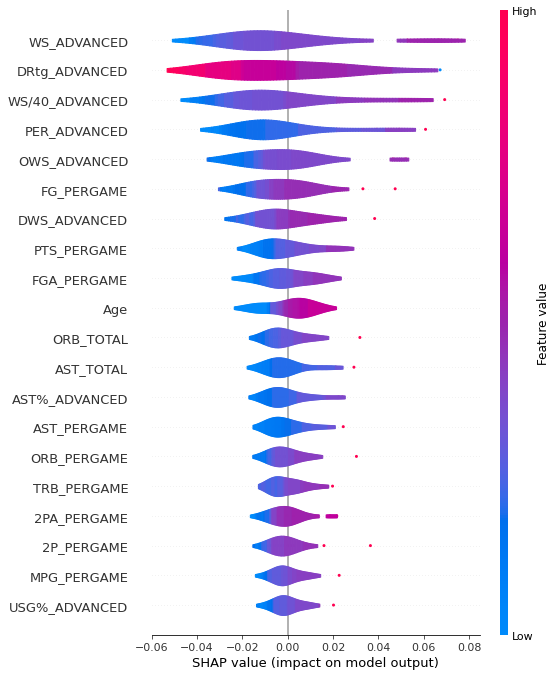

In [259]:
shap.summary_plot(shap_values, scaled_X_test_df,plot_type='violin') #X_test, plot_type='violin') # Top 20 variables

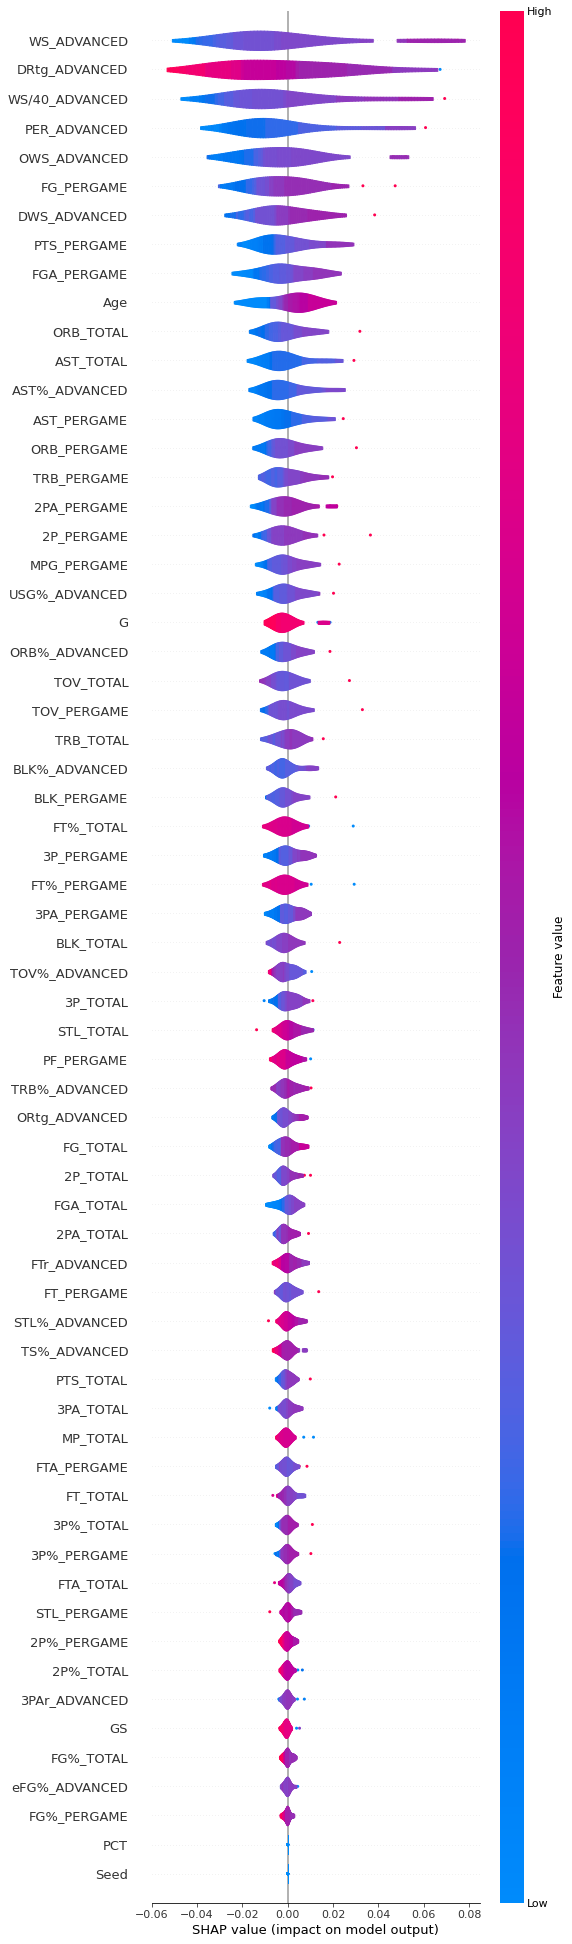

In [260]:
shap.summary_plot(shap_values, X_test, plot_type='violin', max_display=len(X_test.columns)) # All features